# AlBert for Nepali (NepCov19Tweets) Sentiment Analysis.
**Sentiment Analysis on NepCov19Tweets Dataset, a collection of tweets in Nepali (Devnagari Script) regarding/during pandemic period.**

In [18]:
!pip install transformers datasets huggingface-hub --quiet

In [19]:
import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 99

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    set_seed(seed)
    
seed_everything(rand_seed)

## Model Selection and Preparation

### Loading Model
**and model hyper-parameter tuning**

In [20]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained('albert-base-v2',
            id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
            label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2})

All model checkpoint layers were used when initializing TFAlbertForSequenceClassification.

Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
print(model.summary())
model.config

Model: "tf_albert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 albert (TFAlbertMainLayer)  multiple                  11683584  
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 11,685,891
Trainable params: 11,685,891
Non-trainable params: 0
_________________________________________________________________
None


AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "vocab_size": 30000
}

### Optimizer Selection and Hyperparameter Tuning

In [22]:
from transformers import create_optimizer, AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=5e-6, weight_decay_rate=0.001)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


# Dataset Selection and Prepartion

**Loading Dataset**

In [23]:
import datasets

data = datasets.load_dataset("raygx/NepCov19TweetsPlus")
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data = data.rename_columns({"Sentences":"text","Sentiment":"labels"})
data

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 8310
    })
})

### Label Encoding

In [24]:
%%time
def LabelEncoding(x):
    if x['labels']==0:
        x['labels'] = 0#[1,0,0]
    if x['labels']==1:
        x['labels'] =  1#[0,1,0]
    if x['labels']==-1:
        x['labels'] =  2#[0,0,1]
    
    return x

data = data.map(
        LabelEncoding,
        num_proc=4)

data

CPU times: user 24.6 ms, sys: 4.02 ms, total: 28.6 ms
Wall time: 29.2 ms


DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 8310
    })
})

### Tokenization

In [25]:
from transformers import AlbertTokenizerFast

tokenizer = AlbertTokenizerFast.from_pretrained('raygx/Covid-News-Headline-Generator')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'AlbertTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [26]:
%%time

def preprocess_function(rows):
    return globals()['tokenizer'](rows['text'],truncation=True)

print("Tokenizing the data")
tokenized_inputs = data.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=data["train"].column_names,
)
tokenized_inputs = tokenized_inputs.remove_columns(['token_type_ids'])

tokenized_inputs['train'] = tokenized_inputs['train'].add_column(
    name="labels",column=data['train']['labels']
)
tokenized_inputs['test'] = tokenized_inputs['test'].add_column(
    name="labels",column=data['test']['labels']
)

tokenized_inputs

Tokenizing the data
CPU times: user 116 ms, sys: 3.98 ms, total: 120 ms
Wall time: 124 ms


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8310
    })
})

### Initializing the Data Collator

In [27]:
from transformers import DataCollatorWithPadding

print("Initializing Data Collator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, 
                                        max_length=128,
                                        return_tensors="tf")

Initializing Data Collator


In [28]:
print("Preparing Training and Testing sets to TRAIN the MODEL")
tf_train_set = model.prepare_tf_dataset(
    tokenized_inputs["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_inputs["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Preparing Training and Testing sets to TRAIN the MODEL


## Training and Evaluation

In [29]:
%%time

n_epoch = 4

print("Training the model")
history = model.fit(x=tf_train_set, 
          validation_data=tf_test_set,
          epochs=n_epoch)

Training the model
Epoch 1/4
2077/2077 [==============================] - 417s 190ms/step - loss: 0.9286 - val_loss: 0.7834
Epoch 2/4
2077/2077 [==============================] - 386s 186ms/step - loss: 0.7348 - val_loss: 0.7412
Epoch 3/4
2077/2077 [==============================] - 386s 186ms/step - loss: 0.6478 - val_loss: 0.6834
Epoch 4/4
2077/2077 [==============================] - 387s 186ms/step - loss: 0.5620 - val_loss: 0.6788
CPU times: user 21min 14s, sys: 1min 19s, total: 22min 33s
Wall time: 29min 50s


**Loss Graph Visualization**

<Axes: >

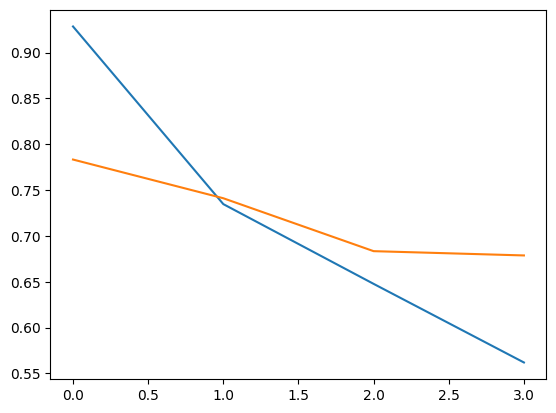

In [30]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [31]:
%%time
from transformers import pipeline, TextClassificationPipeline

print("Getting Test Prediction")
pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer,device=1)
prediction = pipe(data['test']['text'])
pred_labels = [model.config.label2id[x['label']] for x in prediction]

actual_labels = data['test']['labels']

Getting Test Prediction
CPU times: user 29min 9s, sys: 6.58 s, total: 29min 15s
Wall time: 29min 28s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [32]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.7026398594889529
Precision-Score 0.711315229376247
Recall-Score 0.7016847172081829
accuracy_Score 0.7016847172081829


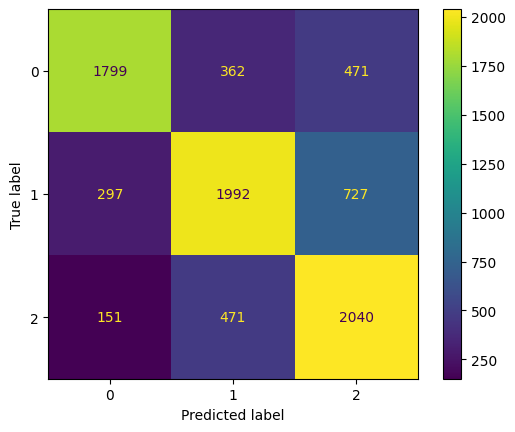

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()